In [1]:
%load_ext autoreload
%autoreload 2

import os
from datetime import datetime
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.tensorboard import SummaryWriter

from market_dynamics import bs_delta, bs_call_price

from data import DataFromFolder, DataRes
from utils import call_payoff, stochastic_integral
from models import ControlNet, EnsembleNet
from train import train_val
from evaluation import get_eval_data
from risk_measures import median_loss

import yfinance as yf
from arch import arch_model
import dask.dataframe as dd

from tqdm import tqdm, trange

from typing import Callable, Optional
import multiprocessing
import time

## Data

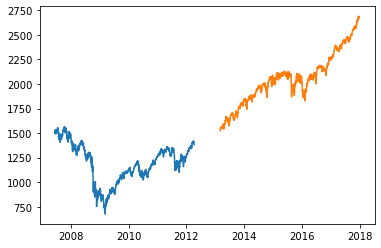

In [2]:
ticker = yf.Ticker('^GSPC')
hist_v1 = ticker.history(start='2013-03-04', end='2018-01-02').Close
hist_v2 = ticker.history(start='2007-06-11', end='2012-04-10').Close
plt.plot(hist_v2);
plt.plot(hist_v1)

In [6]:
# From fitting the GARCH model using R get following parameters

SIGMA_V1 = 0.0643661
SIGMA_V2 = 0.1221684

MU_V1 = 0.048758
MU_V2 = 0.056105

SQRT_252 = 252 ** 0.5

In [7]:
h_params = {"N_SIM": 4000,
            "RF": 0,
            "N_DIMS": 2,
            "FC_DIM": 20,
            "LR": 0.005,
            "GAMMA": 0.96,
            "EPOCHS": 10,
            "BATCH_SIZE": 256,}

In [8]:
initial_value = hist_v2.iloc[0]
strike = initial_value
n_steps = 30
price = bs_call_price(n_steps, initial_value, SIGMA_V2, h_params["RF"], strike)
initial_value, strike, SIGMA_V2, price

(1509.1199951171875, 1509.1199951171875, 0.1221684, 21.0855397479188)

In [9]:
dt = DataFromFolder("v2/", price, call_payoff, {"strike": strike}, splits=h_params["N_SIM"], S0=initial_value, sigma_0=SIGMA_V2, mu_const=MU_V2, take_log=True)


## Training

In [10]:
%%time

# Training three models on different training paths

n_models = 3
models, optimizers, schedulers = [], [], []
n = 1000
val_n = 20
criterion = torch.nn.MSELoss()

for _ in range(n_models):
    model = ControlNet(n_steps, 2, [20, 20], 1, learn_price=False, learn_vol=True)
    models.append(model)
    optimizer = Adam(model.parameters(), lr=h_params["LR"])
    optimizers.append(optimizer)
    schedulers.append(ExponentialLR(optimizer, gamma=h_params["GAMMA"]))

idx_list = np.array_split(np.arange(n) + 1, 3)
val_idx_list = [np.arange(start=idx[-1]+1, stop=idx[-1]+1+val_n) for idx in idx_list]

# Training each model

res_list = []
for model, optimizer, scheduler, indices, val_indices in zip(models, optimizers, schedulers, idx_list, val_idx_list):
    results = train_val(dt, model, criterion, optimizer, h_params["EPOCHS"], indices, val_indices, scheduler, metric=median_loss, val_every=5)
    res_list.append(results)

ens = EnsembleNet(models)

Epoch 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 334/334 [00:25<00:00, 13.22batch/s, loss=62.4, metric=21.4]


validation loss: 928.5533233642578


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 334/334 [00:24<00:00, 13.68batch/s, loss=44.4, metric=18]


validation loss: 415.34756622314455


Epoch 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 333/333 [00:25<00:00, 13.31batch/s, loss=69.3, metric=14]


validation loss: 1241.0244720458984


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 333/333 [00:24<00:00, 13.78batch/s, loss=45.5, metric=14.7]


validation loss: 800.4832458496094


Epoch 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 333/333 [00:26<00:00, 12.35batch/s, loss=46.9, metric=15.6]


validation loss: 188.34401168823243


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 333/333 [00:27<00:00, 12.27batch/s, loss=34.8, metric=14.7]


validation loss: 569.7212753295898


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 333/333 [00:24<00:00, 13.37batch/s, loss=32.8, metric=15]

CPU times: user 14min 32s, sys: 3min 26s, total: 17min 58s
Wall time: 12min 28s


## Performance on GJR validation paths & Delta Hedging Benchmark

In [11]:
# Cython code based on: https://github.com/JackJacquier/python-for-finance/blob/master/Session-7-Cython/Intro_to_Cython.ipynb

In [12]:
%load_ext Cython

In [13]:
%%cython --compile-args=-O3
cimport cython
from libc.math cimport  sqrt,log,exp,erf
cdef double ONE_OVER_SQRT_TWO=0.7071067811865476
import numpy as np
cimport numpy as cnp

@cython.cdivision(True)
@cython.boundscheck(False)
@cython.wraparound(False)
@cython.nonecheck(False)
cdef double gaussian_cdf(double x) nogil:
    return 0.5*(1+erf(x*ONE_OVER_SQRT_TWO))

@cython.cdivision(True)
@cython.boundscheck(False)
@cython.wraparound(False)
@cython.nonecheck(False)
cpdef cnp.ndarray[cnp.double_t, ndim=1] cython_bs_delta(cnp.ndarray[cnp.double_t, ndim=1] sigma, cnp.ndarray[cnp.double_t, ndim=1] S0,double K, cnp.ndarray[cnp.double_t, ndim=1] T):
    cdef int size=len(S0)
    cdef double k, d1, sigmaT
    cdef cnp.ndarray[cnp.double_t, ndim=1] result=np.zeros(size)
        
    with nogil:
        for i in range(size):
            sigmaT = sigma[i] * sqrt(T[i])
            k = log(S0[i] / K)
            d1 = k / sigmaT + 0.5*sigmaT
            result[i] = gaussian_cdf(d1)
        
    return result

In [14]:
# make index to pass decreasing time to maturity to the bs_delta function
idx = np.arange(n_steps) + 1
idx = idx[::-1]

In [15]:
def cython_d_hedge(x, vol):
    return cython_bs_delta(vol.numpy().astype(np.float64), torch.exp(x).numpy().astype(np.float64), strike, idx.astype(np.float64) *  ( 1 / 365))

In [16]:
def hedge_diff(x, x1, x_inc, payoff, price, vol, model=ens, normalized=True):

    # calculate delta hedge; assuming x is log price!
    if normalized:
        path = initial_value * x
    else:
        path = x
    
    d_hedge_list = [cython_d_hedge(a.squeeze(), b.squeeze()) for a, b in zip(path, vol)]
    si_delta = stochastic_integral(x_inc, torch.Tensor(d_hedge_list))
    diff_delta = (price.squeeze() + si_delta).float() - payoff.float()

    # calculating model hedge
    if model.learn_price:
        output, price = model(x, x1)
    else:
        output = model(x, x1)

    si = stochastic_integral(x_inc, output)
    diff = (price.squeeze() + si).float() - payoff.float()

    return diff, diff_delta

In [17]:
diffs, diffs_delta = [], []

for i in np.arange(start=3500, stop=3700):
    
    x, x1, x_inc, payoff, price = dt[i]
    vol = dt.get_vol(i)
    
    diff, diff_delta = hedge_diff(x, x1, x_inc, payoff, price, vol)
    diffs.append(diff)
    diffs_delta.append(diff_delta)
    
d = torch.cat(diffs)
d_delta = torch.cat(diffs_delta)

In [18]:
print('Model:')
print(f"RMSE {(d ** 2).mean() ** 0.5}")
print(f"Using median {(d ** 2).median() ** 0.5}")
print(f"Using mode {(d ** 2).mode()[0] ** 0.5}")

print('Delta Hedge:')
print(f"RMSE {(d_delta ** 2).mean() ** 0.5}")
print(f"Using median {(d_delta ** 2).median() ** 0.5}")
print(f"Using mode {(d_delta ** 2).mode()[0] ** 0.5}")

Model:
RMSE 6.621359825134277
Using median 3.2889022827148438
Using mode 0.2271575927734375
Delta Hedge:
RMSE 15.667876243591309
Using median 9.739227294921875
Using mode 21.085538864135742


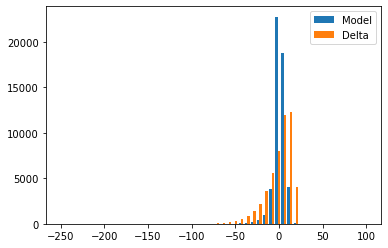

In [19]:
plt.hist([d.detach().numpy(), d_delta.detach().numpy()], range=(-250, 100), bins=50, label=['Model', 'Delta'])
plt.legend();

In [20]:
pd.Series(d_delta.detach()).describe()

count    51200.000000
mean        -0.094304
std         15.667855
min       -204.078278
25%         -7.247254
50%          3.881438
75%         10.595092
max         21.085539
dtype: float64

In [21]:
d_series = pd.Series(d.detach())
d_series.describe()

count    51200.000000
mean         1.124987
std          6.525132
min       -135.143738
25%         -1.441749
50%          1.408454
75%          4.771420
max         36.305290
dtype: float64

## Performance on real paths

In [54]:
# Creating the validation paths
n_steps = 30
step = 5  # number of days by which to shift the window 
valid_paths, valid_prices, valid_strikes = [], [], []

for i in np.arange(start=0, stop=len(hist_v2) - n_steps, step=step):
    
    valid_path = hist_v2[i:i+n_steps+1]
    S0 = valid_path[0]
    valid_price = bs_call_price(n_steps, S0, sigma=SIGMA_V2, rf=0, strike=S0)  # TODO: CORRECT SIGMA HERE    
    
    valid_paths.append(valid_path)
    valid_strikes.append(S0)
    valid_prices.append(valid_price)

valid_paths = np.array(valid_paths)
valid_paths = valid_paths.reshape(valid_paths.shape[0], valid_paths.shape[1], 1)
valid_paths = torch.from_numpy(valid_paths).float()

valid_prices = torch.Tensor(valid_prices)
valid_strikes = torch.Tensor(valid_strikes)

In [55]:
if dt.take_log:
    paths = valid_paths.squeeze().T /  valid_paths[:, 0].squeeze()
    paths = paths.T
    paths = torch.unsqueeze(paths, dim=2)
    paths = torch.log(paths[:, :-1])
    x_inc = valid_paths.squeeze().diff()
    payoff = call_payoff(valid_paths.squeeze(), strike=valid_strikes)

In [56]:
paths.shape

torch.Size([238, 30, 1])

In [64]:
x1 = torch.ones([256, 30, 1]) * SIGMA_V2 #!!!!!!FIX THIS WITH THE SIGMA
output = ens(paths, x1)
si = stochastic_integral(x_inc, output)
diff = (valid_prices.squeeze() + si).float() - payoff.float()
d = diff

In [66]:
print('Model:')
print(f"RMSE {(d ** 2).mean() ** 0.5}")
print(f"Using median {(d ** 2).median() ** 0.5}")

Model:
RMSE 29.437355041503906
Using median 15.217658996582031


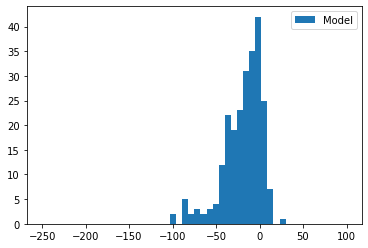

In [69]:
plt.hist(d.detach().numpy(), range=(-250, 100), bins=50, label=['Model'])
plt.legend();

In [68]:
d_series = pd.Series(d.detach())
d_series.describe()

count    238.000000
mean     -18.999050
std       22.532801
min      -99.066925
25%      -31.445137
50%      -14.929764
75%       -2.031241
max       24.538765
dtype: float64

In [31]:
# TODO:
# Sigma not correct yet that is used to caldulate the BS price
# Would also need that to implement delte hedging

## Reservoir paths

In [73]:
res_dt = DataRes('resssim/', price, call_payoff, {"strike": strike}, splits=100, S0=initial_value, take_log=True)

In [80]:
diffs = []

for i in range(100):
    x, x1, x_inc, payoff, price = res_dt[i]
    output = ens(x, x1) #SECOND ARGUMENT VOL RN IT"S PATH
    si = stochastic_integral(x_inc, output)
    diff = (price.squeeze() + si).float() - payoff.float()
    diffs.append(diff)
    
d = torch.cat(diffs)

print('Model:')
print(f"RMSE {(d ** 2).mean() ** 0.5}")
print(f"Using median {(d ** 2).median() ** 0.5}")
print(f"Using mode {(d ** 2).mode()[0] ** 0.5}")

Model:
RMSE 15.098674774169922
Using median 10.466758728027344
Using mode 1.304962158203125


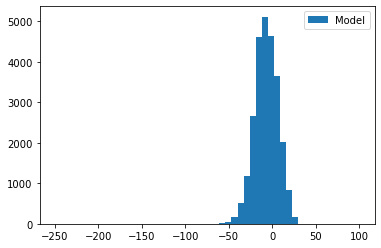

In [81]:
plt.hist(d.detach().numpy(), range=(-250, 100), bins=50, label=['Model'])
plt.legend();

## Compare with training on reservoir paths

In [82]:
%%time

# Training three models on different training paths

n_models = 3
models, optimizers, schedulers = [], [], []
n = 900
val_n = 20
criterion = torch.nn.MSELoss()

for _ in range(n_models):
    model = ControlNet(n_steps, 1, [20, 20], 1, learn_price=False, learn_vol=False)
    models.append(model)
    optimizer = Adam(model.parameters(), lr=h_params["LR"])
    optimizers.append(optimizer)
    schedulers.append(ExponentialLR(optimizer, gamma=h_params["GAMMA"]))

idx_list = np.array_split(np.arange(n) + 1, 3)
val_idx_list = [np.arange(start=idx[-1]+1, stop=idx[-1]+1+val_n) for idx in idx_list]

# Training each model

res_list = []
for model, optimizer, scheduler, indices, val_indices in zip(models, optimizers, schedulers, idx_list, val_idx_list):
    results = train_val(res_dt, model, criterion, optimizer, h_params["EPOCHS"], indices, val_indices, scheduler, metric=median_loss, val_every=5)
    res_list.append(results)

ens = EnsembleNet(models)

Epoch 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:12<00:00, 23.80batch/s, loss=94.5, metric=53.4]


validation loss: 27570.894921875


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:12<00:00, 24.20batch/s, loss=85.8, metric=50.8]


validation loss: 29001.86259765625


Epoch 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:12<00:00, 24.13batch/s, loss=90.8, metric=50.2]


validation loss: 20212.56484375


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:12<00:00, 24.53batch/s, loss=83, metric=46.4]


validation loss: 30420.15751953125


Epoch 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:12<00:00, 24.24batch/s, loss=90.8, metric=54.3]


validation loss: 1572.9624084472657


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:12<00:00, 24.48batch/s, loss=75.9, metric=44.7]


validation loss: 5243.073950195312


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:12<00:00, 24.44batch/s, loss=73.4, metric=43.9]

CPU times: user 6min 49s, sys: 41.3 s, total: 7min 30s
Wall time: 6min 10s


In [83]:
# Out of sample performance

diffs = []

for i in np.arange(n+10,1000):
    x, x1, x_inc, payoff, price = res_dt[i]
    output = ens(x, x1)
    si = stochastic_integral(x_inc, output)
    diff = (price.squeeze() + si).float() - payoff.float()
    diffs.append(diff)
    
d = torch.cat(diffs)

print('Model:')
print(f"RMSE {(d ** 2).mean() ** 0.5}")
print(f"Using median {(d ** 2).median() ** 0.5}")
print(f"Using mode {(d ** 2).mode()[0] ** 0.5}")

Model:
RMSE 8.993473052978516
Using median 7.230739593505859
Using mode 0.1012420654296875


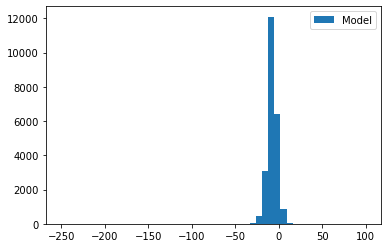

In [84]:
plt.hist(d.detach().numpy(), range=(-250, 100), bins=50, label=['Model'])
plt.legend();

In [85]:
output.shape

torch.Size([256, 30])

In [86]:
# Performance on real data

if dt.take_log:
    paths = valid_paths.squeeze().T /  valid_paths[:, 0].squeeze()
    paths = paths.T
    paths = torch.unsqueeze(paths, dim=2)
    paths = torch.log(paths[:, :-1])
    x_inc = valid_paths.squeeze().diff()
    payoff = call_payoff(valid_paths.squeeze(), strike=valid_strikes)
    
    
output = ens(paths, paths) #VOLLLLL
si = stochastic_integral(x_inc, output)
diff = (valid_prices.squeeze() + si).float() - payoff.float()
d = diff

print('Model:')
print(f"RMSE {(d ** 2).mean() ** 0.5}")
print(f"Using median {(d ** 2).median() ** 0.5}")
print(f"Using mode {(d ** 2).mode()[0] ** 0.5}")

Model:
RMSE 26.957229614257812
Using median 15.382831573486328
Using mode 0.08292579650878906


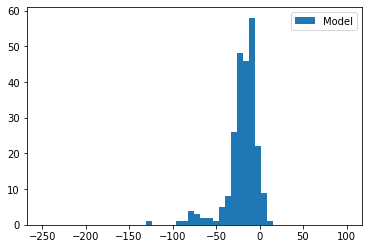

In [87]:
plt.hist(d.detach().numpy(), range=(-250, 100), bins=50, label=['Model'])
plt.legend();

### Plotting training, validation loss & metric

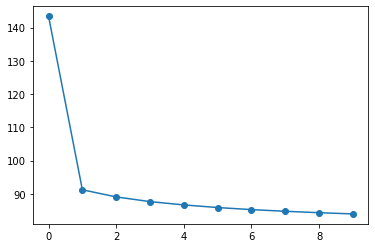

In [88]:
l, vl, m = res_list[1]
plt.plot(l, marker='o')

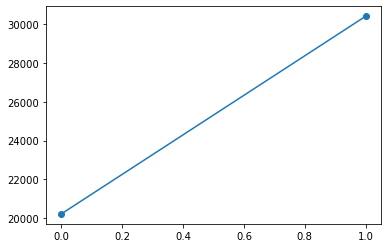

In [89]:
plt.plot(vl, marker='o')

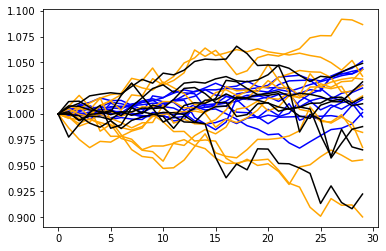

In [91]:
gjr_x, _, _, _, _ = dt[1]
res_x, _, _, _, _ = res_dt[1]
gjr_x, res_x = torch.exp(gjr_x), torch.exp(res_x)

gjr_example_paths = gjr_x[:10]
res_example_paths= res_x[:10]

fut = ticker.history(start='2018-01-02', end='2019-01-02').Close
m = np.floor(len(fut) / n_steps)
real_example_paths = []

for i in np.arange(start=0, stop=(m-1)*n_steps, step=n_steps):
    i = int(i)
    path = fut.iloc[i:i+n_steps].values
    path = path / path[0]
    real_example_paths.append(path)

plt.plot(gjr_example_paths.T.squeeze(), c='blue');
plt.plot(res_example_paths.T.squeeze(), c='orange');
plt.plot(np.array(real_example_paths).T, c='black');